In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy import stats
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.datasets import make_regression
import sklearn
from sklearn.model_selection import GridSearchCV
np.random.seed(10)
#import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from scipy.stats import randint as sp_randint
from scipy.stats import randint as sp_uniform

# Carga de los df de features para entrenar y predecir

In [11]:
windows = ["18_20","19_21","20_22","21_23"]
features = {}
label_auc = {}
label_inst = {}
label_clas_auc = {}
label_clas_inst = {}

for window in windows:
    features[window] = pd.read_csv("windows/{}/features.csv".format(window), index_col="ref_hash")
    label_auc[window] = pd.read_csv("windows/{}/labels_auc.csv".format(window), index_col="ref_hash")
    label_inst[window] = pd.read_csv("windows/{}/labels_inst.csv".format(window), index_col="ref_hash")
    label_clas_auc[window] = pd.DataFrame({'ref_hash': label_auc[window].index, 'label_auc': (label_auc[window]['label_auc'] == 259200).astype(int)}).set_index("ref_hash")
    label_clas_inst[window] = pd.DataFrame({'ref_hash': label_inst[window].index, 'label_inst': (label_inst[window]['label_inst'] == 259200).astype(int)}).set_index("ref_hash")
    
features_to_predict = pd.read_csv("windows/24_26/features.csv", index_col="ref_hash") 

## Selección de features

In [12]:
def select_features(df, feature_list):
    return df.reindex(columns=feature_list)

In [32]:
features_list_class_auc = [
    'appearances_in_auctions', 
    'user_appeared_last_day', 
    'time_to_reappear',
    'amount_of_clicks', 
    'has_installed', 
    #'user_clicked_last_day',
    'user_installed_last_day', 
    'amount_of_installs', 
    #'cant_max_day',
    #'cant_min_day', 
    #'mean_time_to_click', 
    #'max_time_click',
    #'min_time_click', 
    'mean_auctions_per_day', 
    'mean_events_per_day',
    #'mean_clicks_per_day', 
    'amount_auctions_in_last_hour',
    'amount_auctions_in_last_2_hours', 
    'amount_auctions_in_last_5_hours',
    'amount_auctions_in_last_12_hours', 
    'amount_auctions_in_last_24_hours',
    'amount_events_in_last_hour', 
    'amount_events_in_last_2_hours',
    'amount_auctions_in_first_hour', 
    'amount_auctions_in_first_3_hours',
    'amount_auctions_in_first_5_hours', 
    'amount_auctions_in_first_12_hours',
    'amount_events_in_first_hour', 
    'amount_events_in_first_5_hours',
    'amount_events_in_first_12_hours', 
    #'amount_clicks_in_last_2_hours',
    #'amount_clicks_in_last_4_hours', 
    'device_os', 
    #'std_time_to_click',
    'std_time_auctions', 
    #'max_time_install', 
    #'min_time_install',
    #'mean_time_install', 
    #'std_time_install', 
    'max_time_events',
    'min_time_events', 
    'mean_time_events', 
    'std_time_events',
    'installs_per_events', 
    #'installs_per_clicks', 
    'events_x_app_210',
    'events_x_app_122', 
    'events_x_app_65', 
    'events_x_app_121',
    'events_x_app_26', 
    'most_installed_apps_used', 
    'cant_apps_used',
    #'cant_events_atributed', 
    #'has_events_atributed',
    'has_events_ids_with_installs', 
    #'has_events_ids_without_installs',
    'cant_events_0_4', 
    'cant_events_4_8', 
    'cant_events_8_12',
    'cant_events_12_16', 
    'cant_events_16_20', 
    'cant_events_20_24',
    'cant_auctions_0_4', 
    'cant_auctions_4_8', 
    'cant_auctions_8_12',
    'cant_auctions_12_16', 
    'cant_auctions_16_20', 
    'cant_auctions_20_24',
    #'implicit', 
    #'latitude', 
    #'longitude', 
    #'clicked_in_last_5_minutes',
    #'clicked_with_wifi_in_last_3_hours', 
    'hour_install', 
    'hour_events',
    'hour_clicks', 
    'hour_auctions',
    #'amount_auctions_in_last_half_hour',
    #'amount_auctions_in_last_15_minutes',
    'cant_devices'
]

In [51]:
features_list_class_inst = [
    'appearances_in_auctions', 
    'user_appeared_last_day', 
    'time_to_reappear',
    #'amount_of_clicks', 
    'has_installed', 
    'user_clicked_last_day',
    'user_installed_last_day', 
    'amount_of_installs', 
    #'cant_max_day',
    #'cant_min_day', 
    #'mean_time_to_click', 
    #'max_time_click',
    'min_time_click', 
    'mean_auctions_per_day', 
    'mean_events_per_day',
    #'mean_clicks_per_day', 
    'amount_auctions_in_last_hour',
    'amount_auctions_in_last_2_hours', 
    'amount_auctions_in_last_5_hours',
    'amount_auctions_in_last_12_hours', 
    'amount_auctions_in_last_24_hours',
    'amount_events_in_last_hour', 
    'amount_events_in_last_2_hours',
    'amount_auctions_in_first_hour', 
    'amount_auctions_in_first_3_hours',
    'amount_auctions_in_first_5_hours', 
    'amount_auctions_in_first_12_hours',
    'amount_events_in_first_hour', 
    'amount_events_in_first_5_hours',
    'amount_events_in_first_12_hours', 
    #'amount_clicks_in_last_2_hours',
    #'amount_clicks_in_last_4_hours', 
    'device_os', 
    #'std_time_to_click',
    'std_time_auctions', 
    'max_time_install', 
    'min_time_install',
    'mean_time_install', 
    #'std_time_install', 
    'max_time_events',
    'min_time_events', 
    'mean_time_events', 
    'std_time_events',
    'installs_per_events', 
    #'installs_per_clicks', 
    'events_x_app_210',
    'events_x_app_122', 
    'events_x_app_65', 
    'events_x_app_121',
    'events_x_app_26', 
    'most_installed_apps_used', 
    'cant_apps_used',
    #'cant_events_atributed', 
    #'has_events_atributed',
    'has_events_ids_with_installs', 
    #'has_events_ids_without_installs',
    'cant_events_0_4', 
    'cant_events_4_8', 
    'cant_events_8_12',
    'cant_events_12_16', 
    'cant_events_16_20', 
    'cant_events_20_24',
    'cant_auctions_0_4', 
    'cant_auctions_4_8', 
    'cant_auctions_8_12',
    'cant_auctions_12_16', 
    'cant_auctions_16_20', 
    'cant_auctions_20_24',
    'implicit', 
    'latitude', 
    'longitude', 
    #'clicked_in_last_5_minutes',
    'clicked_with_wifi_in_last_3_hours', 
    'hour_install', 
    'hour_events',
    'hour_clicks', 
    'hour_auctions',
    'cant_installs_0_4',
    'cant_installs_4_8', 
    'cant_installs_8_12',
    'cant_installs_12_16',
    'cant_installs_16_20',
    'cant_installs_20_24',
    #'amount_auctions_in_last_half_hour',
    #'amount_auctions_in_last_15_minutes',
    'cant_devices', 
    "mean_appearances_auctions",
    "mean_appearances_events", "mean_appearances_clicks", "mean_appearances_installs"
]

## Funciones útiles para el entrenamento y el balanceo

In [52]:
def get_df_to_train(windows, features, labels, feature_list):
    df_list = []
    for window in windows:
        df = select_features(features[window], feature_list).join(labels[window], how="inner")
        df_list.append(df)
    df_full = pd.concat(df_list)
    df_full.reset_index(inplace=True, drop=True)
    return df_full

In [53]:
# factor = 1 100% balanced
# factor = 0 not balanced
# label_value label que mas aparece y se debe balancear
def balance(df_full, label_name, factor, label_value = 1):
    cant_values = df_full[label_name].value_counts()[label_value]
    cant_no_values = len(df_full[label_name]) - cant_values
    a_borrar = int((cant_values-cant_no_values)*factor)
    index_to_drop = np.random.choice(df_full.loc[df_full[label_name] == label_value].index,a_borrar, replace=False)
    return df_full.drop(index=index_to_drop)

In [54]:
def get_train_test_split(df_full, label_name, test_size=0.3):
    y = df_full[label_name]
    X_data = df_full.drop(label_name, axis=1)
    return train_test_split(X_data, y, test_size=test_size, random_state=7)

# Importancia de los features

In [55]:
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor

> ### ***Importancia de los features de auctions***

In [33]:
df_auctions_importance = get_df_to_train(windows, features, label_auc, features_list_class_auc)
df_auctions_importance = df_auctions_importance.sample(10000)


df_auctions_features = df_auctions_importance.drop('label_auc', axis=1)
df_auctions_labels = df_auctions_importance['label_auc']

X = df_auctions_features.fillna(0)
Y = df_auctions_labels
names = X.columns.tolist()
rf_auc = RandomForestRegressor(n_estimators=100)
rf_auc.fit(X, Y)
#print("Features sorted by their score:")
#print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [34]:
feature_importance_auctions = sorted(zip(map(lambda x: round(x, 4), rf_auc.feature_importances_), names))
feature_auctions_plot = pd.DataFrame(feature_importance_auctions).set_index(1)

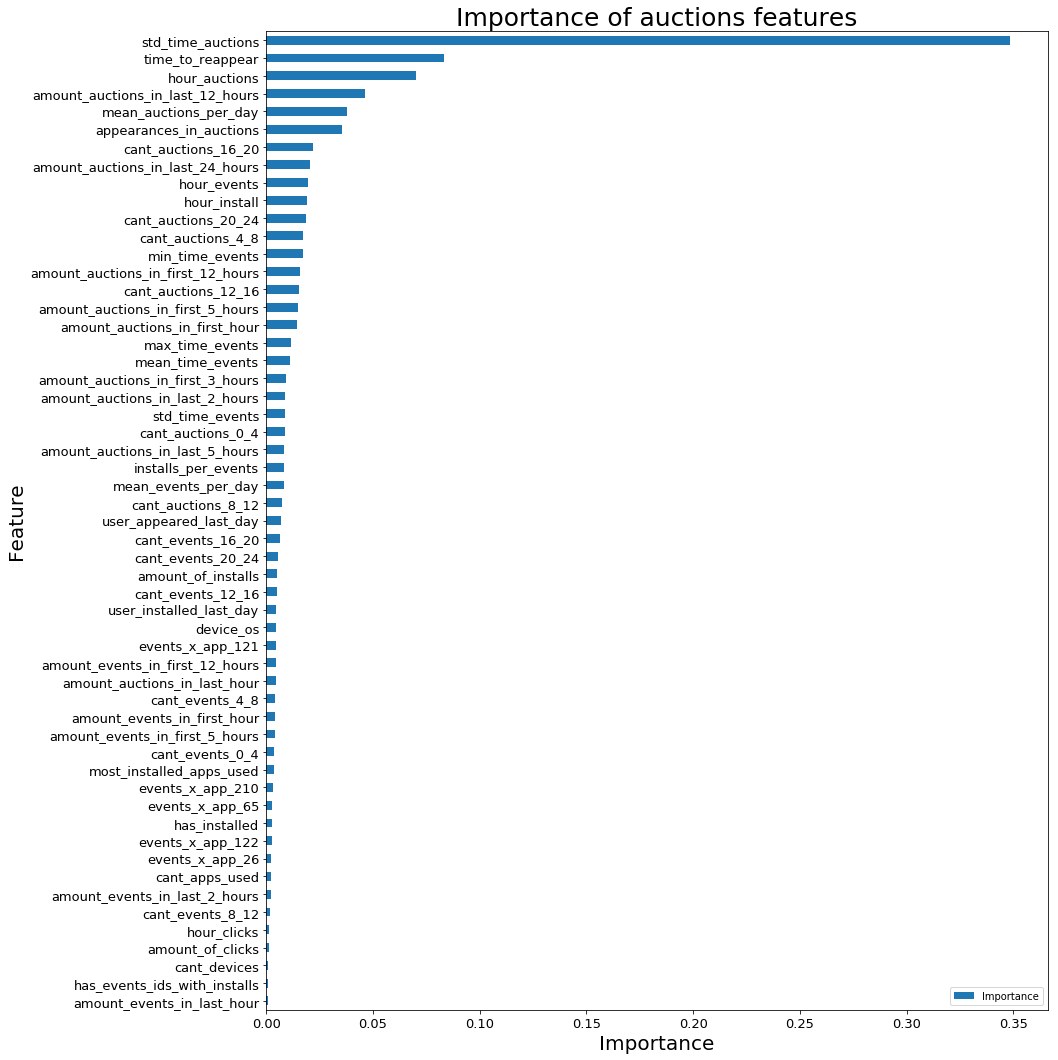

In [45]:
# Ploteo

import matplotlib.pyplot as plt

plot = feature_auctions_plot.plot(kind="barh", figsize=(14,18))
plot.set_title("Importance of auctions features", fontsize=25)
plot.set_ylabel("Feature", fontsize=20)
plot.set_xlabel("Importance", fontsize=20);
plot.legend(["Importance"], loc=4)
plot.tick_params(labelsize=13, which='major')
plt.savefig("importance_auctions.png", bbox_inches="tight")

> ### ***Importancia de los features de installs***

In [56]:
df_installs_importance = get_df_to_train(windows, features, label_inst, features_list_class_inst)
df_installs_importance = df_installs_importance.sample(10000)


df_installs_features = df_installs_importance.drop('label_inst', axis=1)
df_installs_labels = df_installs_importance['label_inst']

X = df_installs_features.fillna(0)
Y = df_installs_labels
names = X.columns.tolist()
rf_inst = RandomForestRegressor(n_estimators=100)
rf_inst.fit(X, Y)
#print("Features sorted by their score:")
#print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [57]:
feature_importance_inst = sorted(zip(map(lambda x: round(x, 4), rf_inst.feature_importances_), names))
feature_inst_plot = pd.DataFrame(feature_importance_inst).set_index(1)

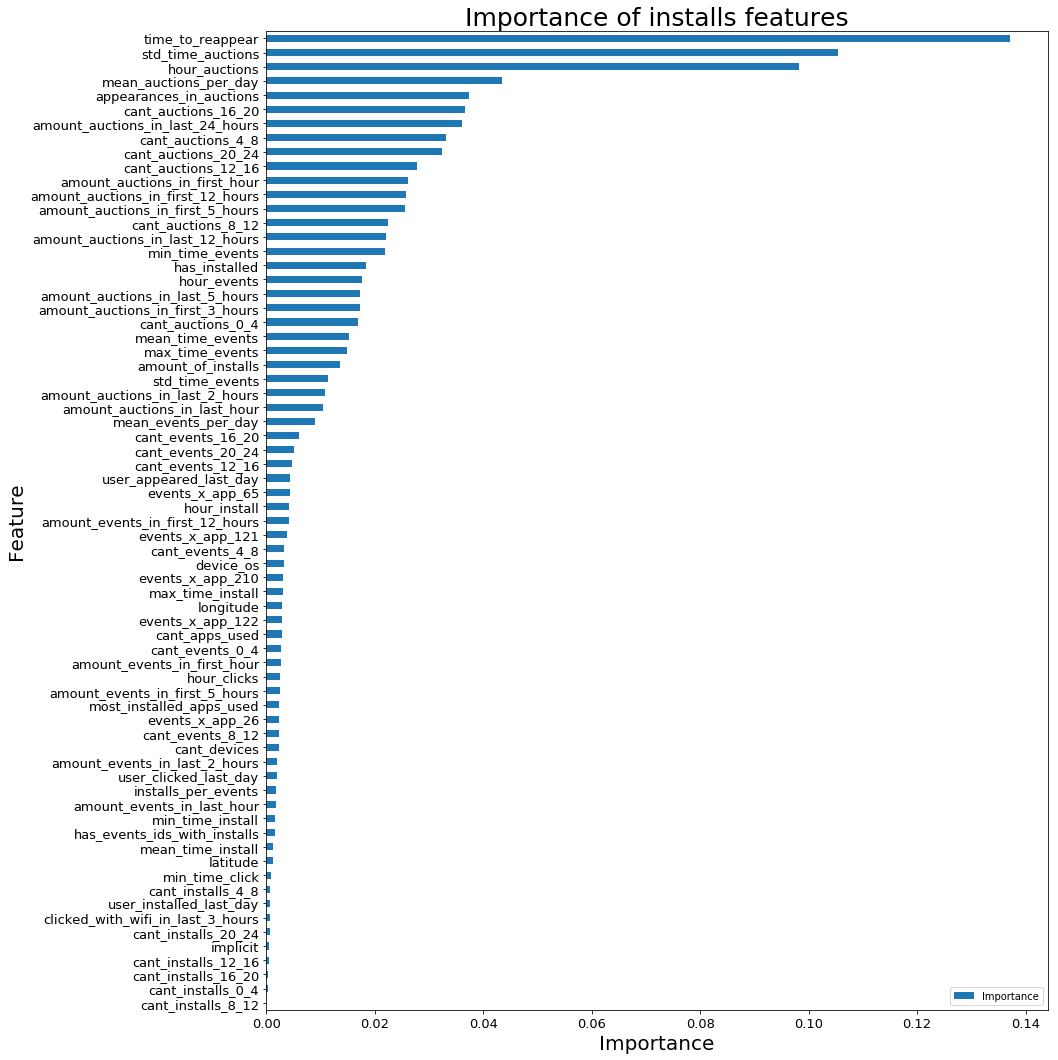

In [58]:
# Ploteo

import matplotlib.pyplot as plt

plot = feature_inst_plot.plot(kind="barh", figsize=(14,18))
plot.set_title("Importance of installs features", fontsize=25)
plot.set_ylabel("Feature", fontsize=20)
plot.set_xlabel("Importance", fontsize=20);
plot.legend(["Importance"], loc=4)
plot.tick_params(labelsize=13, which='major')
plt.savefig("importance_installs.png", bbox_inches="tight")

# ***Modelos***

# **Redes neuronales**

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics

Using TensorFlow backend.


> ### ***Modelo de redes neuronales de predicción de auctions***

In [69]:
df_full_auctions = get_df_to_train(windows, features, label_auc, features_list_class_auc)
df_full_auctions = df_full_auctions.fillna(0)

# Filtro los tiempos máximos.
df_full_auctions = df_full_auctions[df_full_auctions["label_auc"] < 259200]

# Separo train y test.
X_train_auc, X_test_auc, y_train_auc, y_test_auc = get_train_test_split(df_full_auctions, "label_auc")

In [73]:
# Creo el modelo
model_auc_neural = Sequential()

# Capa de entrada
model_auc_neural.add(Dense(10, input_dim=X_train_auc.shape[1], activation='relu'))
# Dropout para controlar el overfit
model_auc_neural.add(Dropout(0.2))

# Capa con 40 neuronas
model_auc_neural.add(Dense(20, activation='relu'))
# Dropout para controlar el overfit
#model_auc_neural.add(Dropout(0.2))

# Capa con 60 neuronas
model_auc_neural.add(Dense(60, activation='relu'))
# Dropout para controlar el overfit
#model_auc_neural.add(Dropout(0.2))

# Capa con 60 neuronas
model_auc_neural.add(Dense(80, activation='relu'))
# Dropout para controlar el overfit
#model_auc_neural.add(Dropout(0.2))

# Salida del modelo
model_auc_neural.add(Dense(1))

# Compilo el modelo
model_auc_neural.compile(optimizer ='adam', loss = 'mean_squared_error', metrics =[metrics.mse])

In [74]:
# Veo el modelo
model_auc_neural.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 10)                720       
_________________________________________________________________
dropout_39 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_65 (Dense)             (None, 20)                220       
_________________________________________________________________
dense_66 (Dense)             (None, 60)                1260      
_________________________________________________________________
dense_67 (Dense)             (None, 80)                4880      
_________________________________________________________________
dense_68 (Dense)             (None, 1)                 81        
Total params: 7,161
Trainable params: 7,161
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Entreno el modelo
model_auc_neural.fit(X_train_auc, y_train_auc, validation_data=(X_test_auc,y_test_auc), epochs=5, batch_size=32)

Train on 704627 samples, validate on 301984 samples
Epoch 1/5
704627/704627 [==============================] - 47s 66us/step - loss: 6076040771.9540 - mean_squared_error: 6076040771.9540 - val_loss: 5102212982.5733 - val_mean_squared_error: 5102212982.5733
Epoch 2/5
704627/704627 [==============================] - 47s 67us/step - loss: 4572109462.1376 - mean_squared_error: 4572109462.1376 - val_loss: 4343436420.4082 - val_mean_squared_error: 4343436420.4082
Epoch 3/5
621056/704627 [=========================>....] - ETA: 5s - loss: 4400947366.7007 - mean_squared_error: 4400947366.7007

In [57]:
# Acá pones el valor que da el "mean_squared_error" del modelo
MSE = 4360503664.0435

print(f"RMSE: {MSE**(1/2)}")

RMSE: 66034.10985273823


> ### ***Modelo de redes neuronales de predicción de installs***

In [46]:
df_full_inst = get_df_to_train(windows, features, label_inst, features_list_class_inst)
df_full_inst = df_full_inst.fillna(0)

# Saco los tiempos máximos

df_full_inst = df_full_inst[df_full_inst["label_inst"] < 259200]
#df_full_inst = balance(df_full_inst, "label_inst", 1, 259200)


# Separo en train y test
X_train_inst, X_test_inst, y_train_inst, y_test_inst = get_train_test_split(df_full_inst, "label_inst")

In [47]:
# Creo el modelo
model_inst_neural = Sequential()

# Capa de entrada
model_inst_neural.add(Dense(10, input_dim=X_train_inst.shape[1], activation='relu'))
# Dropout para controlar el overfit
model_inst_neural.add(Dropout(0.2))

# Capa con 30 neuronas
model_inst_neural.add(Dense(40, activation='relu'))
# Dropout para controlar el overfit
model_inst_neural.add(Dropout(0.2))

# Capa con 50 neuronas
model_inst_neural.add(Dense(60, activation='relu'))
# Dropout para controlar el overfit

# Capa con 20 neuronas
model_inst_neural.add(Dense(30, activation='relu'))
# Dropout para controlar el overfit
model_inst_neural.add(Dropout(0.2))

# Salida del modelo
model_inst_neural.add(Dense(1))

# Compilo el modelo
model_inst_neural.compile(optimizer ='adam', loss = 'mean_squared_error', metrics =[metrics.mse])

In [48]:
# Veo el modelo
model_inst_neural.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 10)                860       
_________________________________________________________________
dropout_16 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 40)                440       
_________________________________________________________________
dropout_17 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 60)                2460      
_________________________________________________________________
dense_29 (Dense)             (None, 30)                1830      
_________________________________________________________________
dropout_18 (Dropout)         (None, 30)                0         
__________

In [49]:
# Entreno el modelo
model_inst_neural.fit(X_train_inst, y_train_inst, validation_data=(X_test_inst,y_test_inst), epochs=50)

Train on 154919 samples, validate on 66395 samples
Epoch 1/50
154919/154919 [==============================] - 9s 58us/step - loss: 15391003852.3915 - mean_squared_error: 15391003852.3915 - val_loss: 14894671627.7329 - val_mean_squared_error: 14894671627.7329
Epoch 2/50
154919/154919 [==============================] - 8s 53us/step - loss: 12517791544.1098 - mean_squared_error: 12517791544.1098 - val_loss: 9809100338.2631 - val_mean_squared_error: 9809100338.2631
Epoch 3/50
154919/154919 [==============================] - 8s 53us/step - loss: 9741268331.2870 - mean_squared_error: 9741268331.2870 - val_loss: 9355052366.5293 - val_mean_squared_error: 9355052366.5293
Epoch 4/50
154919/154919 [==============================] - 8s 54us/step - loss: 8376433830.8737 - mean_squared_error: 8376433830.8737 - val_loss: 6619108251.0189 - val_mean_squared_error: 6619108251.0189
Epoch 5/50
154919/154919 [==============================] - 8s 55us/step - loss: 6572779073.5141 - mean_squared_error: 6572

KeyboardInterrupt: 

In [ ]:
# Acá pones el valor que da el "mean_squared_error" del modelo
MSE = 6272147912.2780

print(f"RMSE: {MSE**(1/2)}")

# **XGBoost**

> ### ***Modelo de XGBoost de predicción de auctions***

In [ ]:
df_full = get_df_to_train(windows, features, label_auc, features_list_class_auc)

df_full = df_full.sample(int(len(df_full)))

#df_full = balance(df_full, "label_auc", 0, 259200)

df_full = df_full.loc[df_full["label_auc"] != 259200]

X_train, X_test, y_train, y_test = get_train_test_split(df_full, "label_auc", 0.2)

In [ ]:
model_auc = xgb.XGBRegressor(   
    gamma=0.1, 
    learning_rate=0.1, 
    max_depth=3,  
    n_estimators=500,
    n_jobs=2,  
    objective='reg:linear',   
    silent=True
)

In [ ]:
%%time
model_auc.fit(X_train, y_train, eval_metric='rmse')
#cv = xgb.cv(params, xg_train, 5000, nfold=n_folds, early_stopping_rounds=early_stopping, verbose_eval=1)
prediction = model_auc.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, prediction))
print("RMSE: %f" % (rmse))

In [ ]:
model_auc.save_model('xgboost_auc.model')

> #### ***Mejor modelo de auctions***

RMSE: 63345.641573
CPU times: user 25min 48s, sys: 8.65 s, total: 25min 57s
Wall time: 26min 8s
    
model_auc = xgb.XGBRegressor(
    base_score=0.5, 
    booster='gbtree', 
    colsample_bylevel=1,
    colsample_bytree=1, 
    gamma=0.1, 
    learning_rate=0.1, 
    max_delta_step=0,
    max_depth=4, 
    min_child_weight=1, 
    missing=None, 
    n_estimators=600,
    n_jobs=1, 
    nthread=None, 
    objective='reg:linear', 
    random_state=0,
    reg_alpha=0, 
    reg_lambda=1, 
    scale_pos_weight=1, 
    seed=None,
    silent=True, 
    subsample=1
)

In [ ]:
_ = plot_importance(model_auc, height=0.5)

In [ ]:
from xgboost import plot_importance, plot_tree
_ = plot_importance(model_auc, height=0.5)

> ### ***Modelo de XGBoost de predicción de installs***

In [ ]:
df_full_installs = get_df_to_train(windows, features, label_inst, features_list_class_inst)

df_full_installs = df_full_installs.sample(int(len(df_full_installs)))

#df_full_installs = balance(df_full_installs, "label_inst", 1, 259200)
df_full_installs = df_full_installs[df_full_installs["label_inst"] != 259200]

X_train, X_test, y_train, y_test = get_train_test_split(df_full_installs, "label_inst", 0.2)

In [ ]:
model_inst = xgb.XGBRegressor(
    learning_rate = 0.1,
    n_estimators=700,
    max_dept=5,
    gamma=0.1,
    n_jobs=-1
)

In [ ]:
%%time
model_inst.fit(X_train, y_train, eval_metric='rmse', verbose=True)

prediction = model_inst.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, prediction))
print("RMSE: %f" % (rmse))

In [ ]:
model_inst.save_model('xgboost_inst.model')

In [ ]:
from xgboost import plot_importance, plot_tree
_ = plot_importance(model_inst, height=0.9)

> #### ***Mejor modelo de installs***

WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 76768.119164
CPU times: user 5min 39s, sys: 2 s, total: 5min 41s
Wall time: 5min 44s

model_inst = xgb.XGBRegressor(
    learning_rate = 0.1,
    n_estimators=700,
    max_dept=5,
    gamma=0.1,
    n_jobs=-1
)"

# **LightGBM**

### LightGBM para auctions

In [ ]:
df_full_auctions = get_df_to_train(windows, features, label_auc, features_list_class_auc)
df_full_auctions = df_full_auctions[df_full_auctions["label_auc"] != 259200]
#df_full_auctions = df_full_auctions.sample()

In [ ]:
X_train_auc, X_test_auc, y_train_auc, y_test_auc = get_train_test_split(df_full_auctions, "label_auc")

In [ ]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train_auc, y_train_auc)
lgb_eval = lgb.Dataset(X_test_auc, y_test_auc, reference=lgb_train)

params = {
    'n_estimators' : 500,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 28,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 326,
    'min_child_weight': 10000.0,
    'reg_alpha': 50,
    'reg_lambda': 0,
    'verbose': 0
}

gbm_auc = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

gbm_auc.save_model('model_light_gbm_auc.txt')

pred_auc_gbm = gbm_auc.predict(X_test_auc, num_iteration=gbm_auc.best_iteration)
print('The rmse of prediction is:', mean_squared_error(y_test_auc, pred_auc_gbm) ** 0.5)

### LightGBM para installs

In [ ]:
df_full_installs = get_df_to_train(windows, features, label_inst, features_list_class_inst)
df_full_installs = df_full_installs[df_full_installs["label_inst"] != 259200]

In [ ]:
X_train_inst, X_test_inst, y_train_inst, y_test_inst = get_train_test_split(df_full_installs, "label_inst")

In [ ]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train_inst, y_train_inst)
lgb_eval = lgb.Dataset(X_test_inst, y_test_inst, reference=lgb_train)

params = {
    'n_estimators' : 500,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 6,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 185,
    'min_child_weight': 100.0,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'verbose': 0
}

gbm_inst = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

gbm_inst.save_model('model_light_gbm_inst.txt')

pred_inst_gbm = gbm_inst.predict(X_test_inst, num_iteration=gbm_inst.best_iteration)
print('The rmse of prediction is:', mean_squared_error(y_test_inst, pred_inst_gbm) ** 0.5)

### Tuneo de hiperparámetros para LightGBM

In [ ]:
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

> ### Tuneo para el modelo de installs

In [ ]:
clf = lgb.LGBMRegressor(max_depth=-1, random_state=314, silent=True, metric='l2', n_jobs=4, n_estimators = 500)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    scoring='neg_mean_squared_error',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

In [ ]:
%%time
gs.fit(X_train_inst, y_train_inst)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

In [ ]:
np.sqrt(gs.best_score_*-1)

In [ ]:
gs.best_params_

In [ ]:
clf_auc = lgb.LGBMRegressor(max_depth=-1, random_state=314, silent=True, metric='l2', n_jobs=4, n_estimators = 500)
gs_auc = RandomizedSearchCV(
    estimator=clf_auc, param_distributions=param_test, 
    scoring='neg_mean_squared_error',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

> ### Tuneo para el modelo de auctions

In [ ]:
df_full_auctions = df_full_auctions.sample(160000)
X_train_auc, X_test_auc, y_train_auc, y_test_auc = get_train_test_split(df_full_auctions, "label_auc")

In [ ]:
%%time
gs_auc.fit(X_train_auc, y_train_auc)
print('Best score reached: {} with params: {} '.format(gs_auc.best_score_, gs_auc.best_params_))

In [ ]:
np.sqrt(gs_auc.best_score_*(-1))

In [ ]:
gs_auc.best_params_

# **Random Forest**

## Random Forest para auctions

In [ ]:
df_full_auctions = get_df_to_train(windows, features, label_auc, features_list_class_auc)
df_full_auctions = df_full_auctions[df_full_auctions["label_auc"] != 259200]

In [ ]:
X_train_auc, X_test_auc, y_train_auc, y_test_auc = get_train_test_split(df_full_auctions, "label_auc")

In [ ]:
random_forest_auc = RandomForestRegressor(
                           n_estimators=100, 
                           min_samples_split = 10, 
                           random_state=100
                         )

#random forest no maneja nulos
X_train_auc = X_train_auc.fillna(0)
X_test_auc = X_test_auc.fillna(0) 

random_forest_auc.fit(X_train_auc, y_train_auc.values.ravel())

params = {'objective': 'reg:squarederror',
          'eta': 0.3,
          'max_depth': 5,
          'min_child_weight': 3,
          'silent': 1,
          'subsample': 0.7,
          'colsample_bytree': 0.7,
          'seed': 1}

num_trees=250

prediction_auc = random_forest_auc.predict(X_test_auc)

rmse = np.sqrt(mean_squared_error(y_test_auc, prediction_auc))
print("RMSE: %f" % (rmse))

## Random Forest para installs

In [ ]:
df_full_inst = get_df_to_train(windows, features, label_inst, features_list_class_inst)
df_full_inst = df_full_inst[df_full_inst["label_inst"] != 259200]

In [ ]:
X_train_inst, X_test_inst, y_train_inst, y_test_inst = get_train_test_split(df_full_inst, "label_inst")

In [ ]:
random_forest_inst = RandomForestRegressor(
                           n_estimators=100, 
                           min_samples_split = 10, 
                           random_state=100
                         )

#random forest no maneja nulos
X_train_inst = X_train_inst.fillna(0)
X_test_inst = X_test_inst.fillna(0) 

random_forest_inst.fit(X_train_inst, y_train_inst.values.ravel())

params = {'objective': 'reg:squarederror',
          'eta': 0.3,
          'max_depth': 5,
          'min_child_weight': 3,
          'silent': 1,
          'subsample': 0.7,
          'colsample_bytree': 0.7,
          'seed': 1}

num_trees=250

prediction_inst = random_forest_inst.predict(X_test_inst)

rmse = np.sqrt(mean_squared_error(y_test_inst, prediction_inst))
print("RMSE: %f" % (rmse))

# Predecir

### Predicción auctions XGBoost

In [ ]:
pred_auctions = model_auc.predict(select_features(features_to_predict, features_list_class_auc))
df_preds_auctions = pd.DataFrame({'ref_hash' : features_to_predict.index, 'obj' : pred_auctions})
df_preds_auctions.to_csv("auctions_predictions_xgboost.csv", index=False) #persistimos los resultados

### Predicción auctions Redes Neuronales

In [ ]:
pred_auctions_neural = model_auc_neural.predict(select_features(features_to_predict, features_list_class_auc).fillna(0))
pred_auctions_neural = np.array(pred_auctions_neural).flatten()
df_preds_auctions_neural = pd.DataFrame({'ref_hash' : features_to_predict.index, 'obj' : pred_auctions_neural})
df_preds_auctions_neural.to_csv("auctions_predictions_neural.csv", index=False) #persistimos los resultados

### Predicción auctions LightGBM

In [ ]:
pred_auc_gbm = gbm_auc.predict(select_features(features_to_predict,features_list_class_auc),\
                               num_iteration=gbm_auc.best_iteration)
df_preds_auc_gbm = pd.DataFrame({'ref_hash' : features_to_predict.index, 'obj' : pred_auc_gbm})
df_preds_auc_gbm.to_csv("auctions_predictions_lightgbm.csv", index=False) #persistimos los resultados

### Predicción auctions Random Forests

In [ ]:
preds_auc_rf = random_forest_auc.predict(select_features(features_to_predict,features_list_class_auc).fillna(0))
df_preds_auc_rf = pd.DataFrame({'ref_hash' : features_to_predict.index, 'obj' : preds_auc_rf})
df_preds_auc_rf.to_csv("auctions_predictions_randomForest.csv", index=False) #persistimos los resultados

### Predicción installs XGBoost

In [ ]:
pred_installs = model_inst.predict(select_features(features_to_predict, features_list_class_inst))
df_preds_installs = pd.DataFrame({'ref_hash' : features_to_predict.index, 'obj' : pred_installs})
df_preds_installs.to_csv("installs_predictions_xgboost.csv", index=False) #persistimos los resultados

### Predicción installs Redes Neuronales

In [ ]:
pred_installs_neural = model_inst_neural.predict(select_features(features_to_predict, features_list_class_inst).fillna(0))
pred_installs_neural = np.array(pred_installs_neural).flatten()
df_preds_installs_neural = pd.DataFrame({'ref_hash' : features_to_predict.index, 'obj' : pred_installs_neural})
df_preds_installs_neural.to_csv("installs_predictions_neural.csv", index=False) #persistimos los resultados

### Predicción installs LightGBM

In [ ]:
pred_inst_gbm = gbm_inst.predict(select_features(features_to_predict,features_list_class_inst),\
                               num_iteration=gbm_inst.best_iteration)
df_preds_inst_gbm = pd.DataFrame({'ref_hash' : features_to_predict.index, 'obj' : pred_inst_gbm})
df_preds_inst_gbm.to_csv("installs_predictions_lightgbm.csv", index=False) #persistimos los resultados

### Predicción installs Random Forests

In [ ]:
preds_inst_rf = random_forest_inst.predict(select_features(features_to_predict,features_list_class_inst).fillna(0))
df_preds_inst_rf = pd.DataFrame({'ref_hash' : features_to_predict.index, 'obj' : preds_inst_rf})
df_preds_inst_rf.to_csv("installs_predictions_randomForest.csv", index=False) #persistimos los resultados

# Parameter Tuning para XGBoost

In [ ]:
df_full = get_df_to_train(windows, features, label_auc, features_list_class_auc)
df_full = df_full.sample(int(len(df_full)*0.1))
df_full = df_full[df_full["label_auc"] != 259200]

#### Max_depth and min_child_weight tuning

In [ ]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring= 'neg_mean_squared_error', n_jobs=4,iid=False, cv=5)
gsearch1.fit(df_full[features_list_class_auc],df_full['label_auc'])
#gsearch1.cv_results_

In [ ]:
np.sqrt(gsearch1.best_score_ * (-1))

In [ ]:
gsearch1.best_params_

> #### Refinamos la búsqueda entre valores acotados

In [ ]:
param_test2 = {
 'max_depth': [3,4,5],
 'min_child_weight': [3,4,5]
}
gsearch2 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.01, n_estimators=1000, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring= 'neg_mean_squared_error', n_jobs=4,iid=False, cv=5)
gsearch2.fit(df_full[features_list_class_auc],df_full['label_auc'])
#gsearch2.cv_results_

In [ ]:
gsearch2.best_params_  #los mejores parámetros son max_depth 4 y min child_weight 3

In [ ]:
np.sqrt(gsearch2.best_score_ * (-1))

#### Learning rate and n_estimators tunning

In [ ]:
param_test3 = {
    'n_estimators' : [100,200,500, 1000],
    'learning_rate' : [0.1, 0.05, 0.01]
}
gsearch3 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators=140, max_depth=3,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test3, scoring= 'neg_mean_squared_error', n_jobs=4,iid=False, cv=5)
gsearch3.fit(df_full[features_list_class_auc],df_full['label_auc'])

In [ ]:
gsearch3.best_params_

In [ ]:
np.sqrt(gsearch3.best_score_ * (-1))

#### Gamma tuning

In [ ]:
param_test4 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch4 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators=200, max_depth=4,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test4, scoring= 'neg_mean_squared_error', n_jobs=4,iid=False, cv=5)
gsearch4.fit(df_full[features_list_class_auc],df_full['label_auc'])

In [ ]:
gsearch4.best_params_

In [ ]:
np.sqrt(gsearch4.best_score_ * (-1))

#### Subsample and colsample_bytree tuning

In [ ]:
param_test5 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch5 = GridSearchCV(estimator = XGBRegressor( learning_rate = 0.1, n_estimators=200, max_depth=4,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:squarederror', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch5.fit(df_full[features_list_class_auc],df_full['label_auc'])

In [ ]:
gsearch5.best_params_

In [ ]:
np.sqrt(gsearch5.best_score_ * (-1))

#### Regularization tuning

In [ ]:
param_test6 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch6 = GridSearchCV(estimator = XGBRegressor( learning_rate = 0.1, n_estimators=200, max_depth=4,
 min_child_weight=3, gamma=0, subsample=0.9, colsample_bytree=0.7,
 objective= 'reg:squarederror', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch6.fit(df_full[features_list_class_auc],df_full['label_auc'])

In [ ]:
gsearch6.best_params_

In [ ]:
np.sqrt(gsearch6.best_score_ * (-1))

# Submit to Kaggle

In [ ]:
def export_df(df, name):
    df.to_csv(name, index=False)

Las predicciones tendrán seteadas como índice los ref_hash para no perder la referencia
No es necesario filtrar los ref_hash y quedarnos solo con los target en las predicciones que obtenemos ya que de eso
se encarga la función 

In [39]:
target = pd.read_csv("target_competencia_ids.csv")

In [ ]:
#df_preds_installs = pd.read_csv("installs_predictions.csv")
#df_preds_auctions = pd.read_csv("auctions_predictions.csv")

In [ ]:
def create_submit_df(auctions_predictions, installs_predictions, target):
    
    target = target.set_index('ref_hash')
    
    auc = auctions_predictions.reset_index()
    auc.columns = ['ref_hash','obj']
    auc['ref_hash'] = auc['ref_hash'].astype(str) + "_st"
    auc = auc.set_index('ref_hash')
    
    ins = installs_predictions.reset_index()
    ins.columns = ['ref_hash','obj']
    ins['ref_hash'] = ins['ref_hash'].astype(str) + "_sc"
    ins = ins.set_index('ref_hash')
    
    frames = [ins,auc]
    submit_result = pd.concat(frames).reset_index()
    target_list = target.reset_index('ref_hash')['ref_hash'].tolist()
    return submit_result.loc[submit_result['ref_hash'].isin(target_list)].sort_values(by = 'ref_hash')

### XGBoost

In [ ]:
kaggle_sub = create_submit_df(df_preds_auctions.set_index('ref_hash'), \
                              df_preds_installs.set_index('ref_hash'), target)

In [ ]:
export_df(kaggle_sub, "submit.csv")

### Neural network

In [ ]:
kaggle_sub_neural = create_submit_df(df_preds_auctions_neural.set_index('ref_hash'), \
                              df_preds_installs_neural.set_index('ref_hash'), target)

In [ ]:
export_df(kaggle_sub_neural, "submit_neural.csv")

In [ ]:
ensamble_df = kaggle_sub.merge(kaggle_sub_neural, on="ref_hash")


In [ ]:
ensamble_df["obj"] = (ensamble_df["obj_x"] + ensamble_df["obj_y"])/2

In [ ]:
ensamble_kaggle = ensamble_df[["ref_hash", "obj"]]

In [ ]:
export_df(ensamble_kaggle, "submit_ensamble.csv")

#### Ensemble XGBoost + LightGBM

In [ ]:
kaggle_sub_lgbm = create_submit_df(df_preds_auc_gbm.set_index('ref_hash'), df_preds_inst_gbm.set_index('ref_hash'), target)
kaggle_sub_xgboost = create_submit_df(df_preds_auctions.set_index('ref_hash'), df_preds_installs.set_index('ref_hash'), target)

In [ ]:
xgboost_submit = kaggle_sub_lgbm.merge(kaggle_sub_xgboost, on = 'ref_hash')

In [ ]:
xgboost_submit['obj'] = (xgboost_submit['obj_x'] + xgboost_submit['obj_y'])/2

In [ ]:
xgboost_submit = xgboost_submit[['ref_hash', 'obj']]

In [ ]:
export_df(xgboost_submit, "submit_leo.csv")

## Ensamble lgbm + random_forests + xgboost

In [ ]:
a_inst = pd.read_csv("installs_predictions_lightgbm.csv")
b_inst = pd.read_csv("installs_predictions_randomForest.csv")
c_inst = pd.read_csv("installs_predictions_xgboost.csv")

In [ ]:
a_auc = pd.read_csv("auctions_predictions_lightgbm.csv")
b_auc = pd.read_csv("auctions_predictions_randomForest.csv")
c_auc = pd.read_csv("auctions_predictions_xgboost.csv")

In [36]:
a_b_inst = a_inst.merge(b_inst, on="ref_hash")
all_inst = a_b_inst.merge(c_inst, on = "ref_hash")
all_inst['obj'] = (all_inst['obj_x'] + all_inst['obj_y'] + all_inst['obj'])/3
all_inst = all_inst[['ref_hash', 'obj']]

In [38]:
a_b_auc = a_auc.merge(b_auc, on="ref_hash")
all_auc = a_b_auc.merge(c_auc, on = "ref_hash")
all_auc['obj'] = (all_auc['obj_x'] + all_auc['obj_y'] + all_auc['obj'])/3
all_auc = all_auc[['ref_hash', 'obj']]

In [43]:
submit = create_submit_df(all_auc.set_index('ref_hash'), all_inst.set_index('ref_hash'), target)

In [44]:
export_df(submit, "submit.csv")